1. Import Necessary Libraries


In [8]:
pip install tqdm


  Using cached tqdm-4.66.5-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.66.5-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 4.3 MB/s eta 0:00:0000:0100:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 3.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [9]:
import sys
print(sys.path)

['/Users/rrenoir/miniforge3/envs/tf-macos-env/lib/python39.zip', '/Users/rrenoir/miniforge3/envs/tf-macos-env/lib/python3.9', '/Users/rrenoir/miniforge3/envs/tf-macos-env/lib/python3.9/lib-dynload', '', '/Users/rrenoir/miniforge3/envs/tf-macos-env/lib/python3.9/site-packages', '/Users/rrenoir/miniforge3/envs/tf-macos-env/lib/python3.9/site-packages/setuptools/_vendor']


Note: you may need to restart the kernel to use updated packages.


In [5]:
# Cell 1: Import Libraries
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


In [6]:
import librosa
import numpy as np

def normalize_loudness(y):
    """Normalize audio to have consistent loudness."""
    rms = np.sqrt(np.mean(y**2))
    if rms > 0:
        y = y / rms
    return y

def load_and_preprocess_audio(file_path, target_sr=16000):
    """Load and preprocess audio file."""
    y, sr = librosa.load(file_path, sr=None)
    # Downsample if necessary
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    # Normalize loudness
    y = normalize_loudness(y)
    return y


In [7]:
# Path to your dataset folder
dataset_path = '../dataset'

def segment_audio(y, sr, segment_length=3.0, hop_length=1.0):
    """Segment audio into overlapping chunks."""
    segment_samples = int(segment_length * sr)
    hop_samples = int(hop_length * sr)
    segments = []
    for start in range(0, len(y) - segment_samples + 1, hop_samples):
        end = start + segment_samples
        segments.append(y[start:end])
    return segments

def estimate_tempo(y, sr=16000):
    """Estimate the tempo of an audio signal."""
    try:
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr, trim=False)
        if tempo == 0:
            tempo = np.nan  # Handle zero tempo
    except Exception as e:
        print(f"Error estimating tempo: {e}")
        tempo = np.nan
    return tempo


# Get list of audio files
audio_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.wav')]

# Preprocess and store audio segments and tempo labels
audio_segments = []
tempo_labels = []

for file in tqdm(audio_files, desc='Loading and preprocessing audio files'):
    y = load_and_preprocess_audio(file)
    segments = segment_audio(y, sr=16000, segment_length=3.0, hop_length=1.0)
    for segment in segments:
        # Estimate tempo for each segment
        tempo = estimate_tempo(segment)
        audio_segments.append(segment)
        tempo_labels.append(tempo)

# Convert tempo_labels to a NumPy array
tempo_labels = np.array(tempo_labels)

# Identify valid indices where tempo is not NaN
valid_indices = ~np.isnan(tempo_labels)

# Filter the audio_segments and tempo_labels
audio_segments = [audio_segments[i] for i in range(len(audio_segments)) if valid_indices[i]]
tempo_labels = tempo_labels[valid_indices]


Loading and preprocessing audio files:   0%|          | 0/615 [00:00<?, ?it/s]

In [8]:
def extract_features(y, sr=16000):
    # Tempogram features
    oenv = librosa.onset.onset_strength(y=y, sr=sr)
    tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr)
    tempogram_mean = np.mean(tempogram, axis=1)
    
    # MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)
    
    # Chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    
    # Spectral Contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast_mean = np.mean(contrast, axis=1)
    
    # Concatenate all features
    features = np.concatenate((tempogram_mean, mfcc_mean, chroma_mean, contrast_mean))
    return features


In [9]:
feature_vectors = []

for y in tqdm(audio_segments, desc='Extracting features'):
    features = extract_features(y)
    feature_vectors.append(features)

# Convert feature_vectors to a NumPy array
feature_vectors = np.array(feature_vectors)

print("Shape of feature_vectors:", feature_vectors.shape)


Extracting features:   0%|          | 0/5638 [00:00<?, ?it/s]

Shape of feature_vectors: (5638, 416)


In [14]:
# Normalize features
feature_mean = np.mean(feature_vectors, axis=0)
feature_std = np.std(feature_vectors, axis=0)
feature_std[feature_std == 0] = 1e-6  # Avoid division by zero
feature_vectors_normalized = (feature_vectors - feature_mean) / feature_std

print("Feature vectors normalized shape:", feature_vectors_normalized.shape)




Feature vectors normalized shape: (5638, 416)


In [11]:
max_tempo = np.max(tempo_labels)
tempo_labels_normalized = tempo_labels / max_tempo


In [12]:
train_features, val_features, train_labels, val_labels = train_test_split(
    feature_vectors_normalized, tempo_labels_normalized, test_size=0.2, random_state=42)

train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(32).shuffle(1000)
val_dataset = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).batch(32)


In [23]:
# Define the model
input_size = feature_vectors_normalized.shape[1]
hidden_size = 128

model = models.Sequential([
    layers.Input(shape=(input_size,)),
    layers.Dense(hidden_size, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(hidden_size // 2, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


In [24]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='mae')


Epoch 1/200
 91/141 [==================>...........] - ETA: 0s - loss: 0.0723
Epoch 1: val_loss improved from inf to 0.07620, saving model to checkpoints_04/best_tempo_model_06_speed.h5
141/141 [==============================] - 0s 671us/step - loss: 0.0726 - val_loss: 0.0762
Epoch 2/200
 97/141 [===================>..........] - ETA: 0s - loss: 0.0731
Epoch 2: val_loss improved from 0.07620 to 0.07590, saving model to checkpoints_04/best_tempo_model_06_speed.h5
141/141 [==============================] - 0s 636us/step - loss: 0.0726 - val_loss: 0.0759
Epoch 3/200
 99/141 [====================>.........] - ETA: 0s - loss: 0.0733
Epoch 3: val_loss did not improve from 0.07590
141/141 [==============================] - 0s 608us/step - loss: 0.0732 - val_loss: 0.0762
Epoch 4/200
  1/141 [..............................] - ETA: 0s - loss: 0.0615

/Users/rrenoir/miniforge3/envs/tf-macos-env/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 98/141 [===================>..........] - ETA: 0s - loss: 0.0736
Epoch 4: val_loss did not improve from 0.07590
141/141 [==============================] - 0s 616us/step - loss: 0.0735 - val_loss: 0.0762
Epoch 5/200
104/141 [=====================>........] - ETA: 0s - loss: 0.0733
Epoch 5: val_loss did not improve from 0.07590
141/141 [==============================] - 0s 578us/step - loss: 0.0735 - val_loss: 0.0760
Epoch 6/200
100/141 [====================>.........] - ETA: 0s - loss: 0.0722
Epoch 6: val_loss improved from 0.07590 to 0.07581, saving model to checkpoints_04/best_tempo_model_06_speed.h5
141/141 [==============================] - 0s 623us/step - loss: 0.0722 - val_loss: 0.0758
Epoch 7/200
101/141 [====================>.........] - ETA: 0s - loss: 0.0720
Epoch 7: val_loss did not improve from 0.07581
141/141 [==============================] - 0s 592us/step - loss: 0.0728 - val_loss: 0.0759
Epoch 8/200
 97/141 [===================>..........] - ETA: 0s - loss: 0.0739
Epoch

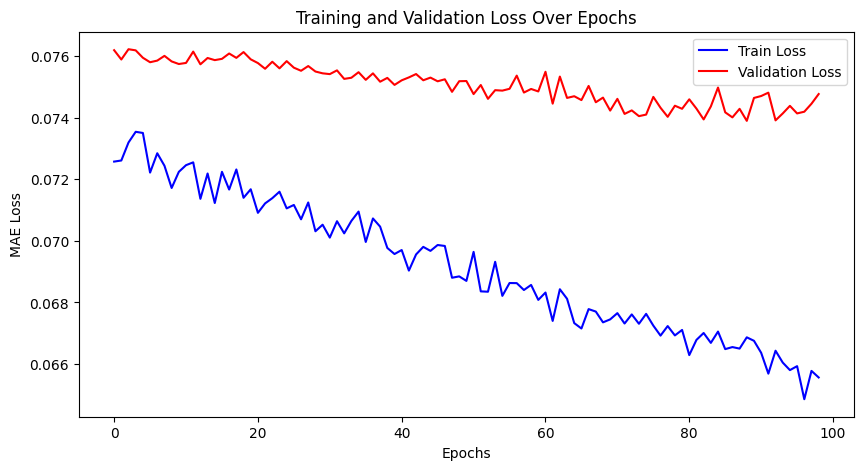

In [32]:
checkpoint_dir = 'checkpoints_04'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best_tempo_model_06_speed.h5'),
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=10, monitor='val_loss', mode='min', verbose=1
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=200,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label="Train Loss", color="blue")
plt.plot(history.history['val_loss'], label="Validation Loss", color="red")
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE Loss')
plt.legend()
plt.show()


1/1 [==============================] - 0s 8ms/step
Mean Absolute Error in Tempo Estimation: 23.09 BPM


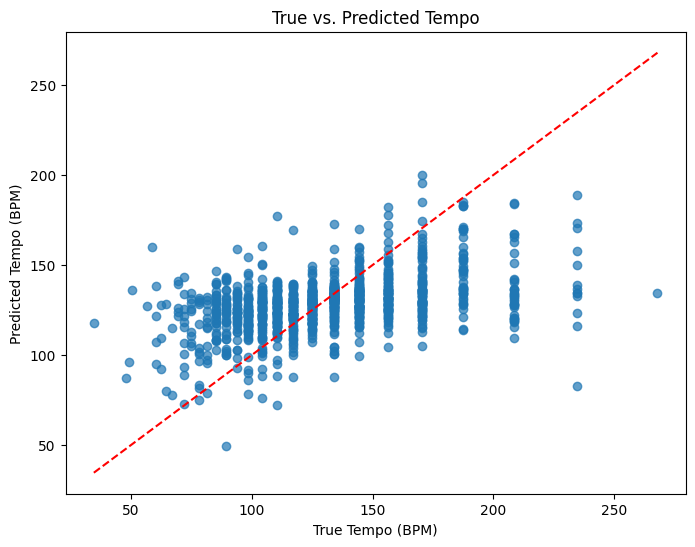

In [33]:
from sklearn.metrics import mean_absolute_error

# Load best model
model.load_weights('checkpoints_04/best_tempo_model_06_speed.h5')

true_tempos = []
predicted_tempos = []

for val_data, val_labels in val_dataset:
    outputs = model.predict(val_data)
    true_tempos.extend(val_labels.numpy())
    predicted_tempos.extend(outputs.flatten())

true_tempos_rescaled = [t * max_tempo for t in true_tempos]
predicted_tempos_rescaled = [p * max_tempo for p in predicted_tempos]

mae = mean_absolute_error(true_tempos_rescaled, predicted_tempos_rescaled)
print(f"Mean Absolute Error in Tempo Estimation: {mae:.2f} BPM")

# Plot true vs. predicted tempos
plt.figure(figsize=(8, 6))
plt.scatter(true_tempos_rescaled, predicted_tempos_rescaled, alpha=0.7)
plt.plot([min(true_tempos_rescaled), max(true_tempos_rescaled)],
         [min(true_tempos_rescaled), max(true_tempos_rescaled)], 'r--')
plt.xlabel('True Tempo (BPM)')
plt.ylabel('Predicted Tempo (BPM)')
plt.title('True vs. Predicted Tempo')
plt.show()


In [34]:
from tensorflow.keras.models import load_model

# Load the Keras .h5 model
keras_model = load_model('checkpoints_04/best_tempo_model_06_speed.h5')


In [35]:
# Save as a TensorFlow SavedModel
keras_model.save('checkpoints_04/tf_saved_model', save_format='tf')


INFO:tensorflow:Assets written to: checkpoints_04/tf_saved_model/assets


INFO:tensorflow:Assets written to: checkpoints_04/tf_saved_model/assets


In [36]:
import tensorflow as tf

# Convert the SavedModel to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model('checkpoints_04/tf_saved_model')
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('checkpoints_04/best_tempo_model_06_speed.tflite', 'wb') as f:
    f.write(tflite_model)


2024-10-18 13:22:42.680685: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-10-18 13:22:42.680698: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-10-18 13:22:42.680938: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: checkpoints_04/tf_saved_model
2024-10-18 13:22:42.681494: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-10-18 13:22:42.681499: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: checkpoints_04/tf_saved_model
2024-10-18 13:22:42.682427: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-10-18 13:22:42.682944: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-10-18 13:22:42.702214: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path

In [37]:
pip install tensorflowjs


  Using cached tensorflowjs-4.21.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached tensorflow-2.17.0-cp39-cp39-macosx_12_0_arm64.whl.metadata (4.1 kB)
  Using cached tf_keras-2.17.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached packaging-23.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached optax-0.2.3-py3-none-any.whl.metadata (8.3 kB)
  Using cached orbax_checkpoint-0.6.4-py3-none-any.whl.metadata (1.8 kB)
  Using cached ml_dtypes-0.4.1-cp39-cp39-macosx_10_9_universal2.whl.metadata (20 kB)
  Using cached tensorboard-2.17.1-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.6.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached wurlitzer-3.1.1-py3-none-any.whl.metadata (2.5 kB)
Using cached tensorflowjs-4.21.0-py3-none-any.whl (89 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.3/731.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.5 MB/s eta 0:00:00
   ━━━━━

In [38]:
tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model checkpoints_04/tf_saved_model checkpoints_04/tfjs_model


SyntaxError: cannot assign to operator (3059052985.py, line 1)

In [39]:
import subprocess

# Run the TensorFlow.js converter from Python
subprocess.run([
    "tensorflowjs_converter",
    "--input_format=tf_saved_model",
    "--output_format=tfjs_graph_model",
    "checkpoints_04/tf_saved_model",
    "checkpoints_04/tfjs_model"
])

I0000 00:00:1729250942.852778 2627091 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)


CompletedProcess(args=['tensorflowjs_converter', '--input_format=tf_saved_model', '--output_format=tfjs_graph_model', 'checkpoints_04/tf_saved_model', 'checkpoints_04/tfjs_model'], returncode=0)